# Métricas de Avaliação de aprendizado - Terceiro Desafio de Projeto

Seguindo as instruções do professor Diego Renan, faremos agora os cálculos das métricas de avaliação de modelos deep learning, utilizando os resultados do treinamento de reconhecimento de padrões fixados em uma matriz de confusão.

Começamos com o carregamento do ambiente.

*Following Professor Diego Renan's instructions, we will now calculate the metrics for evaluating deep learning models, using the results of the pattern recognition training established in a confusion matrix.*

*We begin by loading the environment.*

In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing

Tensorflow version 2.15.0


In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')


tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on a TPU w/8 cores


O conjunto de dados MNIST (Modified National Institute of Standards and Technology) é uma grande base de dados de dígitos manuscritos que é normalmente utilizada para treinar vários sistemas de processamento de imagem e modelos de aprendizagem automática.

O trecho de código a seguir representa a divisão das imagens em dois grupos, treinamento e validação (teste), juntamente com o `reshape` para um determinado número total de imagens de 28x28 pixels com 1 canal de cor `(6000, 28, 28, 1)`. Após aplicamos a normalização das cores de pixels por 255 para estar entre o range de 0 e 1, facilitando o rápido aprendizado da rede.

Cada classe da lista `classes` representa os números de 0 a 9 desenhadas em papel.

*The Modified National Institute of Standards and Technology (MNIST) dataset is a large dataset of handwritten digits that is commonly used to train various image processing systems and machine learning models.*

*The following code snippet represents the division of the images into two groups, training and validation (testing), along with the reshaping for a given total number of 28x28 pixel images with 1 color channel (6000, 28, 28, 1). We then normalize the pixel colors by 255 to be between the range of 0 and 1, increasing models performance.*

*Each class in the classes list represents the numbers 0 to 9 drawn on paper.*

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

train_images, test_images = train_images / 255.0, test_images / 255.0

classes=[0,1,2,3,4,5,6,7,8,9]

11490434/11490434 [==============================] - 0s 0us/step


Agora, dentro do escopo da nossa `tpu_strategy` (utiliza o ambiente TPU ao invés de GPU), montamos um modelo simples com 3 camadas de convolução 2D (utilizando 32 filtros 3x3 na primeira camada, seguido de 64 filtros de 3x3 nas camadas adjacentes) realizando a Rectified Linear Unit (regressão não linear que funciona como linear) para o treinamento da rede.

*Now, within the scope of our `tpu_strategy` (it uses the TPU environment instead of GPU), we set up a simple model with 3 2D convolution layers (using 32 3x3 filters in the first layer, followed by 64 3x3 filters in the adjacent layers) performing the Rectified Linear Unit (non-linear regression that works like linear) for training the network.*

In [4]:
with tpu_strategy.scope():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
model.fit(x=train_images,
            y=train_labels,
            epochs=3,
            validation_data=(test_images, test_labels))

Epoch 1/3
1875/1875 [==============================] - 25s 12ms/step - loss: 0.1529 - accuracy: 0.9537 - val_loss: 0.0612 - val_accuracy: 0.9809
Epoch 2/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0512 - accuracy: 0.9842 - val_loss: 0.0616 - val_accuracy: 0.9806
Epoch 3/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0536 - val_accuracy: 0.9838


In [6]:
y_true=test_labels
y_pred=model.predict(test_images)

313/313 [==============================] - 6s 13ms/step


Como `model.predict_classes()` foi descontinuado, agora usamos a fórmula abaixo para obter as previsões de classes, onde `np.argmax(y_pred, axis=1)` retorna uma matriz numpy com a previsão de classe

*Since `model.predict_classes()` has been deprecated, we now use the formula below to get the classes predictions where `np.argmax(y_pred, axis=1)` returns an numpy array with the class prediction*

In [7]:
print(y_pred.shape)
print(y_pred[0])
y_pred_after = np.argmax(y_pred, axis=1)
print(y_pred_after.shape)
print(y_pred_after[0])

(10000, 10)
[6.6972050e-09 3.2300707e-10 7.7427126e-07 1.8137715e-07 4.1326209e-10
 6.9152162e-10 2.6084398e-14 9.9999702e-01 2.8121315e-07 1.7903146e-06]
(10000,)
7


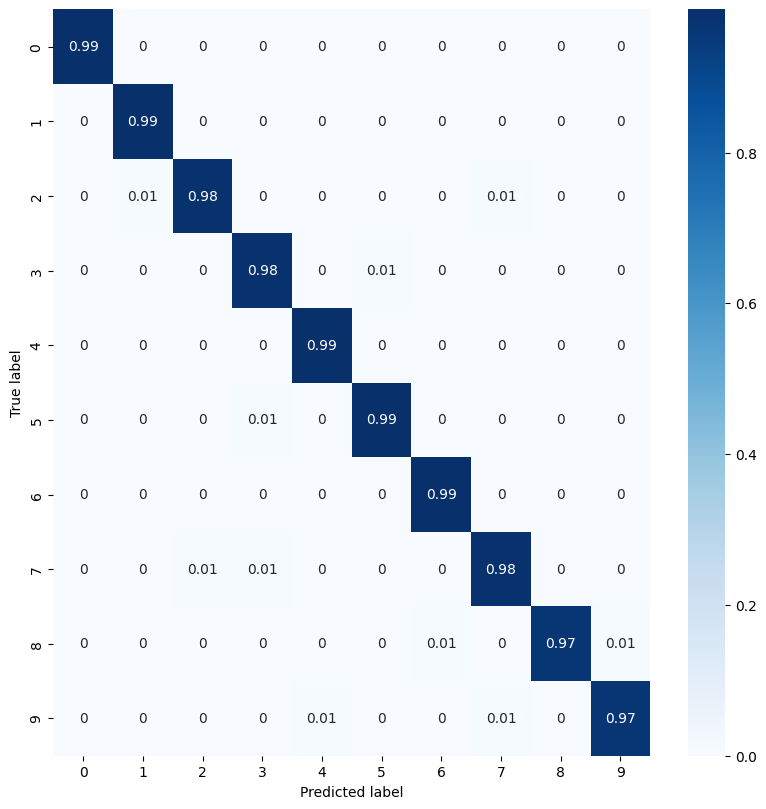

In [8]:
with tpu_strategy.scope():
  con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred_after).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                       index = classes,
                       columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Agora com os resultados da confusion matrix plotados no gráfico acima, calcularemos a acurácia, sensibilidade, fscore e curva de hoc.

*Now with the confusion matrix results plotted in the graphs above, we will calculate the accuracy, sensitivity, fscore and hoc curve.*

In [9]:
# Sensibilidade geral
sen = metrics.recall_score(y_true, y_pred_after, average='macro')
print('Sensibilidade geral: ', sen, '\n')

# Precisão
pre = metrics.precision_score(y_true, y_pred_after, average='macro')
print('Precisão: ', pre, '\n')

# Acuracia
acc = metrics.accuracy_score(y_true, y_pred_after)
print('Acurácia: ', acc, '\n')

# F-score
fscore = metrics.f1_score(y_true, y_pred_after, average='macro')
print('F-score: ', fscore, '\n')

# Roc auc
roc_auc = metrics.roc_auc_score(y_true, y_pred, multi_class='ovr', average='weighted')
print('ROC AUC: ', roc_auc, '\n')

Sensibilidade geral:  0.9837494848918211 

Precisão:  0.9837156961875749 

Acurácia:  0.9838 

F-score:  0.98371047271003 

ROC AUC:  0.9998013342505441 



Para calcularmos o gráfico com a curva roc precisamos primeiro garantir os valores para a taxa de verdadeiros positivos (TVP, ou sensibilidade) e a taxa de falsos positivos (TFP, ou especificidade) para cada classe.

O código abaixo foi extraído do [**Github de Vinícius Trevisan**](https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb) e modificado para interpretar nossos dados multiclasse.

A primeira função define as taxas extraídas da matriz de confusão pelos índices `TN[0,0] FP[0,1] FN[1,0] TP[1,1]`

A segunda função `get_all_roc_coordinates` itera sobre cada probabilidade calculada pelo modelo, para cada classe, e calcula as taxas TVP e TFP fazendo uma comparação entre o real valor orginal e o valor predito pelo modelo.

A terceira função `plot_roc_curve` recebe os valores TVP e TFP e plota a curva de roc. O parâmetro `ax` funciona como um objeto axes do matplotlibe e funciona apenas como um costumizador de gráfico.

*To calculate the ROC curve graph, we first need to ensure the values ​​for the true positive rate (TVP, or sensitivity) and the false positive rate (FPR, or specificity) for each class.*

The code below was extracted from [**Vinícius Trevisan's Github**](https://github.com/vinyluis/Articles/blob/main/ROC%20Curve%20and%20ROC%20AUC/ROC%20Curve%20-%20Multiclass.ipynb) and modified to interpret our multiclass data.

*The first function defines the rates extracted from the confusion matrix by the indices `TN[0,0] FP[0,1] FN[1,0] TP[1,1]`*

*The second function `get_all_roc_coordinates` iterates over each probability calculated by the model, for each class, and calculates the TVP and TFP rates by comparing the original real value and the value predicted by the model.*

*The third function `plot_roc_curve` receives the TVP and TFP values ​​and plots the roc curve. The `ax` parameter works like a matplotlibe axes object and works only as a graph customizer.*

In [10]:
def calculate_tpr_fpr(y_real, y_pred):
    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations

    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes

    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''

    # Calculates the confusion matrix and recover each element
    cm = tf.math.confusion_matrix(y_real, y_pred).numpy()
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate

    return tpr, fpr

In [11]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a threshold for the predicion of the class.

    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.

    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [12]:
def plot_roc_curve(tpr, fpr, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).

    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''

    sns.lineplot(x = fpr, y = tpr, ax = ax)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

Esta seção transforma as probabilidades previstas em um formato estruturado de DataFrame, que é então usado para calcular e plotar curvas ROC para avaliar o desempenho do modelo de classificação em uma base por classe. Essencialmente, ele cria um cenário de classificação binária para cada classe para avaliar quão bem o modelo distingue entre essa classe e todas as outras classes. O modelo OvR (One vs Rest) foi usado pois é a comparação que queremos neste caso específico (chance de previsão correta do numero 0 sobre todos outros números).

This section transforms the predicted probabilities into a structured DataFrame format, which is then used to calculate and plot ROC curves for evaluating the performance of the classification model on a per-class basis. It essentially creates a binary classification scenario for each class to evaluate how well the model distinguishes between that class and all other classes. OvR (One vs Rest) model was used because it is the comparison we want in this specific case (chance of correct prediction of number 0 over all other numbers).


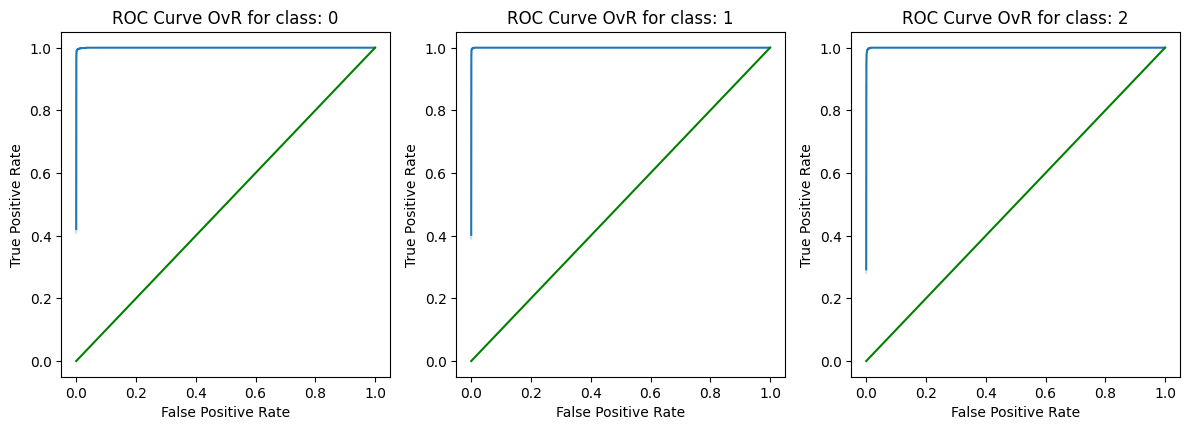

In [13]:
# Plots the Probability Distributions and the ROC Curves One vs Rest for classes 0, 1, and 2
plt.figure(figsize=(12, 8))
roc_auc_ovr = {}

# Filter classes to only include 0, 1, and 2
selected_classes = [0, 1, 2]

for i, c in enumerate(selected_classes):  # Iterate through selected classes with index

    # Use the generated column names, and remove 'target' from columns
    df_aux = pd.DataFrame(test_labels)
    df_aux['class'] = [1 if y == c else 0 for y in test_labels]
    df_aux['prob'] = y_pred[:, c]  # Use the correct column for probability
    df_aux = df_aux.reset_index(drop=True)

    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 3, i + 4)  # Adjust subplot index
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, ax=ax_bottom)
    ax_bottom.set_title(f"ROC Curve OvR for class: {c}")

    # Calculates the ROC AUC OvR
    roc_auc_ovr[c] = metrics.roc_auc_score(df_aux['class'], df_aux['prob'])

plt.tight_layout()

# Interpretação do valor AUC
Os valores de AUC fornecem uma referência rápida para você entender o desempenho do modelo. Quando o AUC está próximo de 1, nosso modelo está no topo de avaliação.

A curva de quase noventa graus dos gráficos acima indicam que o modelo está performando próximo do perfeito.

*AUC values ​​provide a quick reference to help you understand how well your model is performing. When the AUC is close to 1, your model is at the top of its game.*

*The nearly ninety-degree curve in the graphs above indicates that the model is performing close to perfection.*

# Referências

[***MNIST - Ultralytics YOLO Docs***](https://docs.ultralytics.com/pt/datasets/classify/mnist/#:~:text=O%20conjunto%20de%20dados%20MNIST%20(Modified%20National%20Institute%20of%20Standards,e%20modelos%20de%20aprendizagem%20autom%C3%A1tica.)

[***AUC e a curva ROC no aprendizado de máquina***](https://www.datacamp.com/pt/tutorial/auc)

[***Multiclass classification evaluation with ROC Curves and ROC AUC - Vinícius Trevisan***](https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a)